# Task 3: Spatial Heterogeneity and Spatial Stationarity Analysis

In [23]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from shapely.geometry import Point
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from scipy.spatial.distance import pdist
import warnings
warnings.filterwarnings('ignore')

# Loading dataset
df_full = pd.read_csv('final_preprocessed_earthquake_data.csv')

# Sampling 10,000 points 
if len(df_full) > 10000:
    df_sample = df_full.sample(n=10000, random_state=42)
else:
    df_sample = df_full

# Create GeoDataFrame
geometry = [Point(xy) for xy in zip(df_sample['longitude'], df_sample['latitude'])]
gdf_sample = gpd.GeoDataFrame(df_sample, geometry=geometry, crs='EPSG:4326')

try:
    world = gpd.read_file("https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_countries.zip")
except Exception as e:
    print("World map download failed. Plotting data on blank canvas.")
    world = gpd.GeoDataFrame(geometry=[])

print(f"Data Loaded. Full Grid Analysis N={len(df_full)}, Scatter Analysis N={len(df_sample)}")

Data Loaded. Full Grid Analysis N=175947, Scatter Analysis N=10000


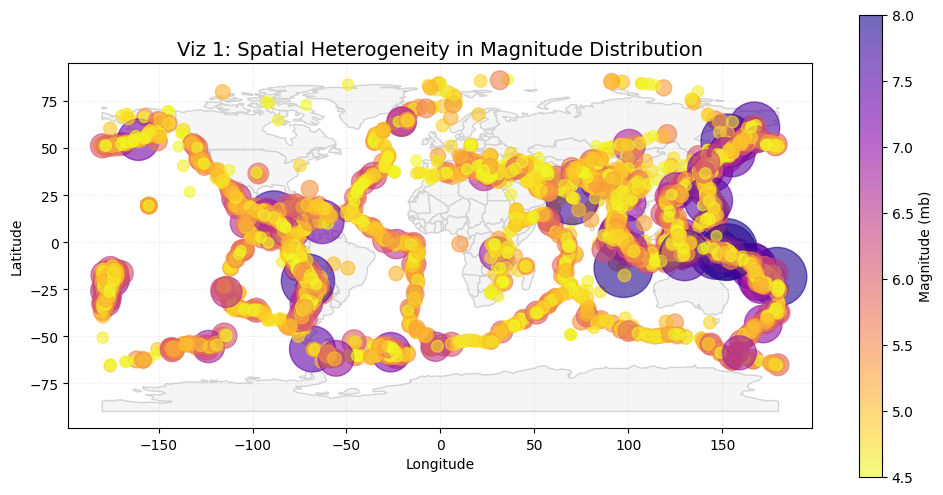

In [24]:
# Viz 1: Global Bubble Map (Magnitude Heterogeneity)

fig, ax = plt.subplots(figsize=(12, 6))
if not world.empty: world.plot(ax=ax, color='whitesmoke', edgecolor='lightgrey')

sc = ax.scatter(gdf_sample['longitude'], gdf_sample['latitude'], 
                s=np.exp(gdf_sample['mag'])/1.5, 
                c=gdf_sample['mag'], cmap='plasma_r', alpha=0.6)

plt.colorbar(sc, label='Magnitude (mb)')
plt.title('Viz 1: Spatial Heterogeneity in Magnitude Distribution', fontsize=14)
plt.xlabel('Longitude'); plt.ylabel('Latitude')
plt.grid(True, linestyle=':', alpha=0.3)
plt.show()

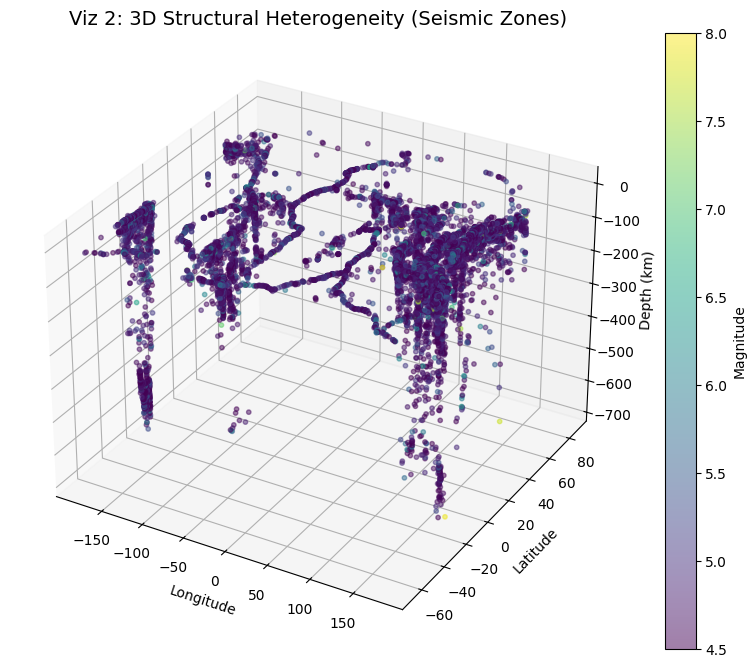

In [25]:
# Viz 2: 3D Structural Heterogeneity (Lat, Lon, Depth)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Invert depth so 'down' is negative
p = ax.scatter(df_sample['longitude'], df_sample['latitude'], -df_sample['depth'], 
               c=df_sample['mag'], cmap='viridis', s=10, alpha=0.5)

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_zlabel('Depth (km)')
plt.colorbar(p, label='Magnitude')
plt.title('Viz 2: 3D Structural Heterogeneity (Seismic Zones)', fontsize=14)
plt.show()

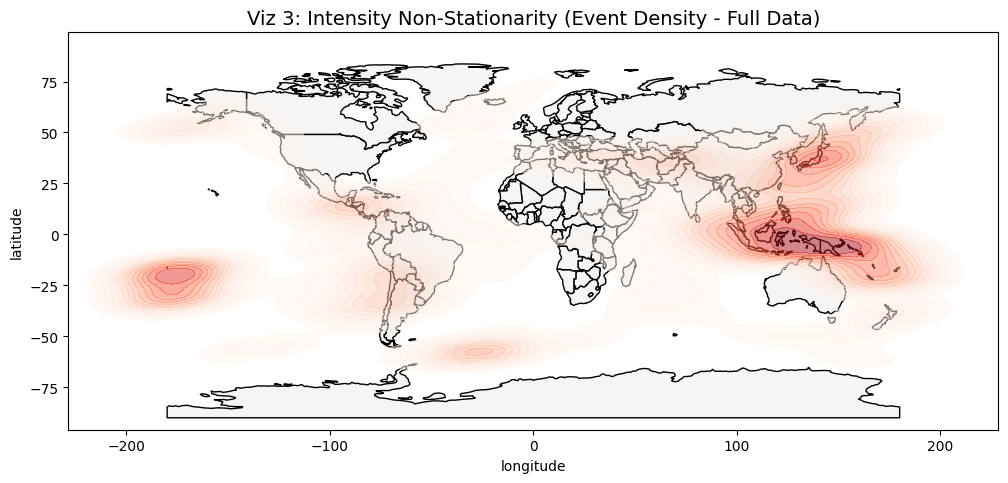

In [26]:
# Viz 3: Process Intensity (Kernel Density Estimate)

fig, ax = plt.subplots(figsize=(12, 6))
if not world.empty: world.plot(ax=ax, color='whitesmoke', edgecolor='black')

# KDE Plot
sns.kdeplot(x=df_full['longitude'], y=df_full['latitude'], 
            fill=True, cmap='Reds', alpha=0.5, levels=15, thresh=0.05, ax=ax)

plt.title('Viz 3: Intensity Non-Stationarity (Event Density - Full Data)', fontsize=14)
plt.show()

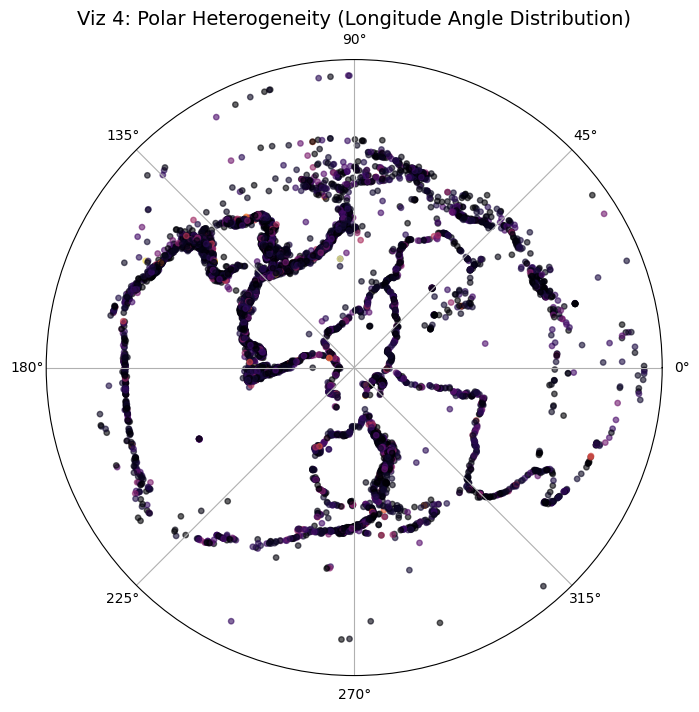

In [27]:
# Viz 4: Polar Projection (Angle Heterogeneity).
theta = np.deg2rad(df_sample['longitude'])
r = df_sample['latitude'] + 90 # Shift Lat to 0-180 for polar plot

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='polar')
c = ax.scatter(theta, r, c=df_sample['mag'], cmap='inferno', s=15, alpha=0.6)

ax.set_yticks([])
plt.title('Viz 4: Polar Heterogeneity (Longitude Angle Distribution)', fontsize=14)
plt.show()

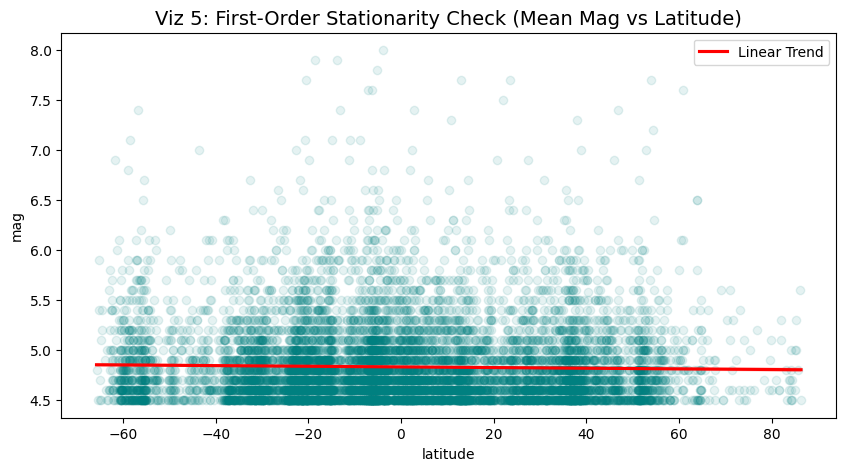

In [28]:
# Viz 5: Latitudinal Drift (Trend Check)

plt.figure(figsize=(10, 5))
sns.regplot(x='latitude', y='mag', data=df_sample, 
            scatter_kws={'alpha':0.1, 'color':'teal'}, 
            line_kws={'color':'red', 'label': 'Linear Trend'})

plt.title('Viz 5: First-Order Stationarity Check (Mean Mag vs Latitude)', fontsize=14)
plt.legend()
plt.show()

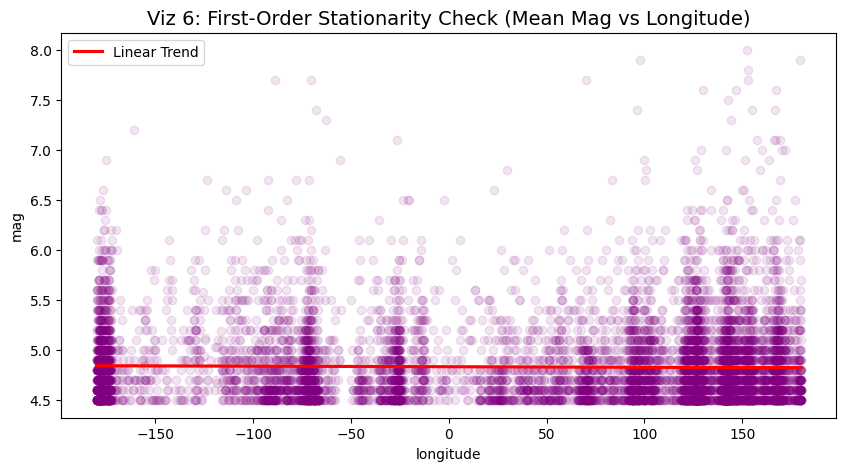

In [29]:
# Viz 6: Longitudinal Drift (Trend Check)

plt.figure(figsize=(10, 5))
sns.regplot(x='longitude', y='mag', data=df_sample, 
            scatter_kws={'alpha':0.1, 'color':'purple'}, 
            line_kws={'color':'red', 'label': 'Linear Trend'})

plt.title('Viz 6: First-Order Stationarity Check (Mean Mag vs Longitude)', fontsize=14)
plt.legend()
plt.show()

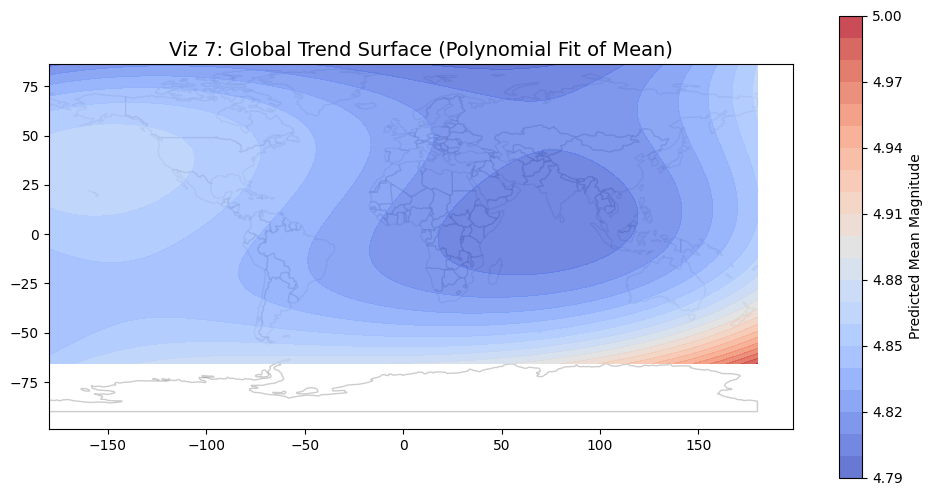

In [30]:
# Viz 7: Global Trend Surface (Polynomial Regression)

X = df_sample[['longitude', 'latitude']].values
y = df_sample['mag'].values

poly = PolynomialFeatures(degree=3)
X_poly = poly.fit_transform(X)
model = LinearRegression().fit(X_poly, y)

# Grid for plotting prediction surface
x_surf = np.linspace(df_sample.longitude.min(), df_sample.longitude.max(), 100)
y_surf = np.linspace(df_sample.latitude.min(), df_sample.latitude.max(), 100)
xx, yy = np.meshgrid(x_surf, y_surf)
zz = model.predict(poly.transform(np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)

fig, ax = plt.subplots(figsize=(12, 6))
if not world.empty: world.plot(ax=ax, facecolor='none', edgecolor='black', alpha=0.2)

contour = ax.contourf(xx, yy, zz, cmap='coolwarm', levels=20, alpha=0.8)
plt.colorbar(contour, label='Predicted Mean Magnitude')
plt.title('Viz 7: Global Trend Surface (Polynomial Fit of Mean)', fontsize=14)
plt.show()

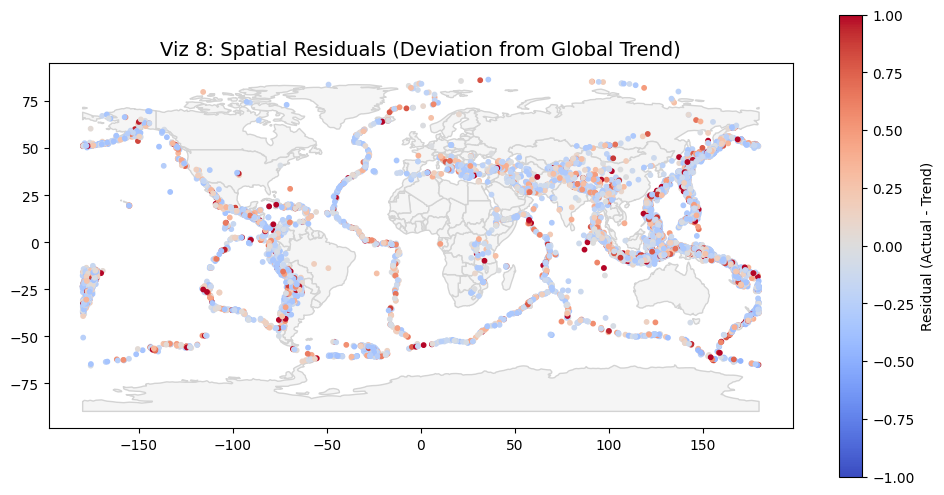

In [31]:
# Viz 8: Spatial Residuals (Unexplained Heterogeneity)

df_sample['trend_pred'] = model.predict(X_poly)
df_sample['residual'] = df_sample['mag'] - df_sample['trend_pred']

fig, ax = plt.subplots(figsize=(12, 6))
if not world.empty: world.plot(ax=ax, color='whitesmoke', edgecolor='lightgrey')
sc = ax.scatter(df_sample['longitude'], df_sample['latitude'], 
                c=df_sample['residual'], cmap='coolwarm', s=10, vmin=-1, vmax=1)

plt.colorbar(sc, label='Residual (Actual - Trend)')
plt.title('Viz 8: Spatial Residuals (Deviation from Global Trend)', fontsize=14)
plt.show()

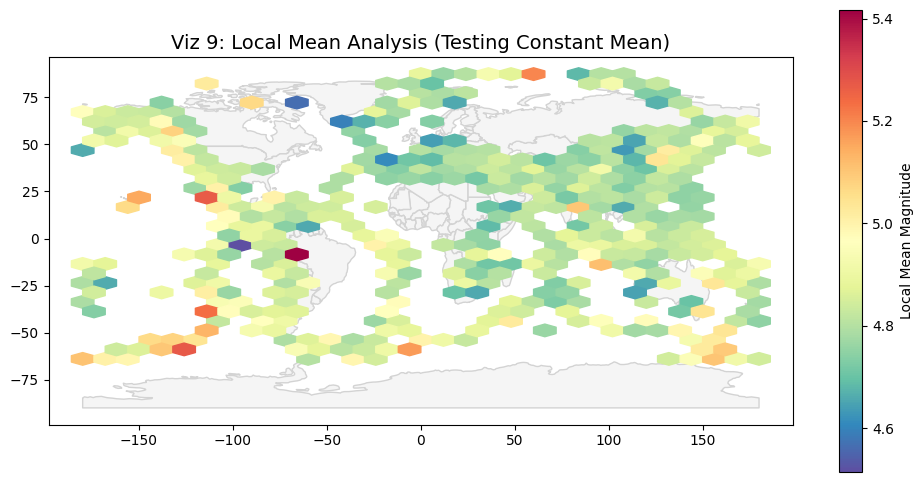

In [32]:
# Viz 9: Local Mean Map (Hexbin Aggregation)

fig, ax = plt.subplots(figsize=(12, 6))
if not world.empty: world.plot(ax=ax, color='whitesmoke', edgecolor='lightgrey')

hb = ax.hexbin(df_full['longitude'], df_full['latitude'], C=df_full['mag'], 
               gridsize=30, cmap='Spectral_r', reduce_C_function=np.mean, mincnt=5)

plt.colorbar(hb, label='Local Mean Magnitude')
plt.title('Viz 9: Local Mean Analysis (Testing Constant Mean)', fontsize=14)
plt.show()

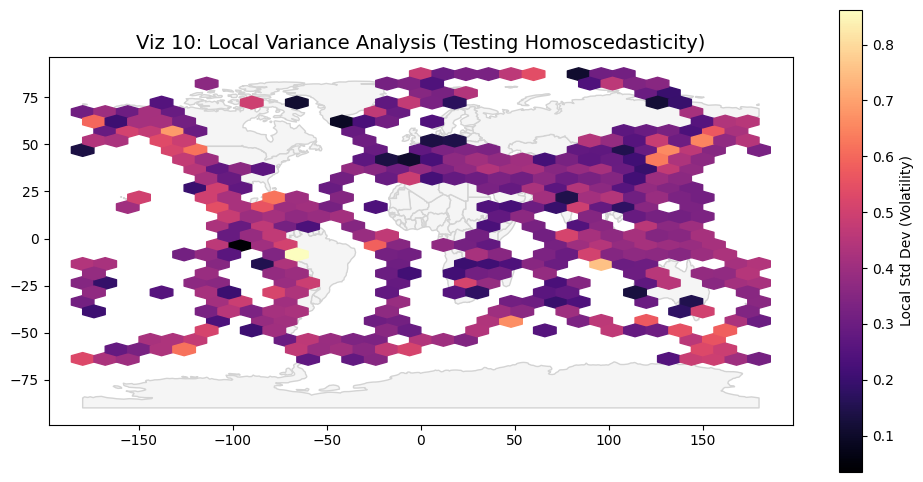

In [33]:
# Viz 10: Local Variance Map (Heteroscedasticity Check)

fig, ax = plt.subplots(figsize=(12, 6))
if not world.empty: world.plot(ax=ax, color='whitesmoke', edgecolor='lightgrey')

hb = ax.hexbin(df_full['longitude'], df_full['latitude'], C=df_full['mag'], 
               gridsize=30, cmap='magma', reduce_C_function=np.std, mincnt=5)

plt.colorbar(hb, label='Local Std Dev (Volatility)')
plt.title('Viz 10: Local Variance Analysis (Testing Homoscedasticity)', fontsize=14)
plt.show()

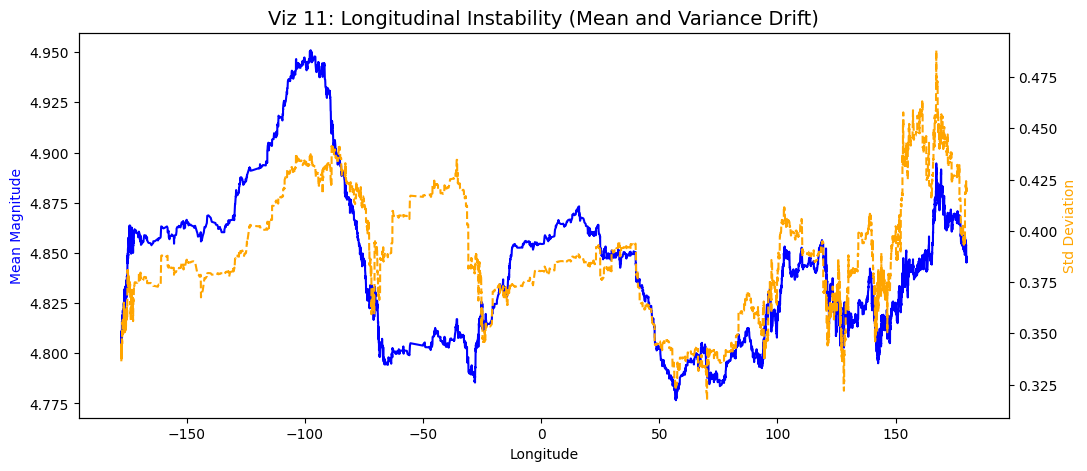

In [34]:
# Viz 11: Rolling Statistics along Longitude

df_sorted = df_sample.sort_values('longitude')
rolling_mean = df_sorted['mag'].rolling(window=500).mean()
rolling_std = df_sorted['mag'].rolling(window=500).std()

fig, ax1 = plt.subplots(figsize=(12, 5))

ax1.plot(df_sorted['longitude'], rolling_mean, color='blue', label='Moving Mean')
ax1.set_ylabel('Mean Magnitude', color='blue')
ax1.set_xlabel('Longitude')

ax2 = ax1.twinx()
ax2.plot(df_sorted['longitude'], rolling_std, color='orange', linestyle='--', label='Moving Std Dev')
ax2.set_ylabel('Std Deviation', color='orange')

plt.title('Viz 11: Longitudinal Instability (Mean and Variance Drift)', fontsize=14)
plt.show()

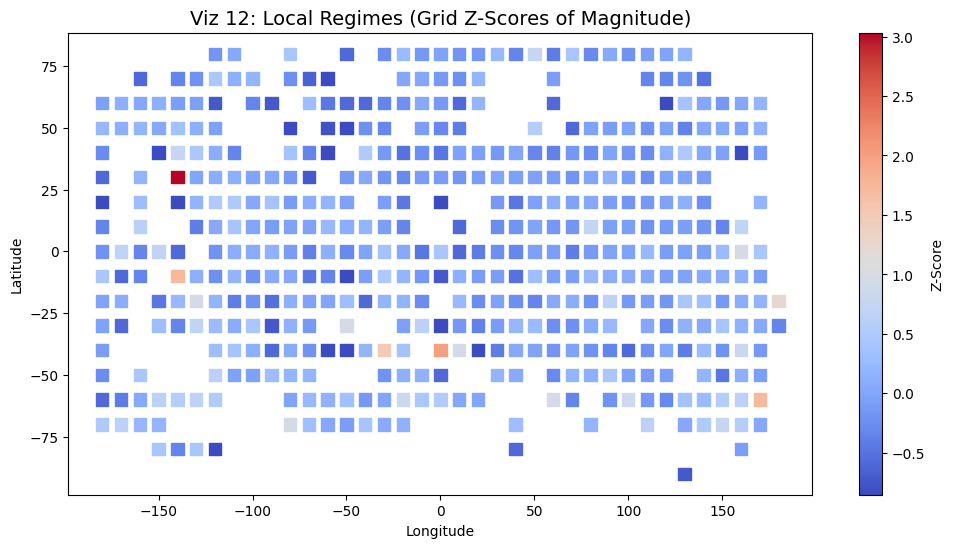

In [35]:
# Viz 12: Hotspot Identification (Z-Score of Grid Means)

df_full['lon_bin'] = (df_full['longitude'] // 10) * 10
df_full['lat_bin'] = (df_full['latitude'] // 10) * 10

grid_stats = df_full.groupby(['lon_bin', 'lat_bin'])['mag'].mean().reset_index()

# Calculate Z-score relative to global mean
global_mean = df_full['mag'].mean()
global_std = df_full['mag'].std()
grid_stats['z_score'] = (grid_stats['mag'] - global_mean) / global_std

plt.figure(figsize=(12, 6))
plt.scatter(grid_stats['lon_bin'], grid_stats['lat_bin'], 
            c=grid_stats['z_score'], cmap='coolwarm', s=80, marker='s')
plt.colorbar(label='Z-Score')
plt.title('Viz 12: Local Regimes (Grid Z-Scores of Magnitude)', fontsize=14)
plt.xlabel('Longitude'); plt.ylabel('Latitude')
plt.show()

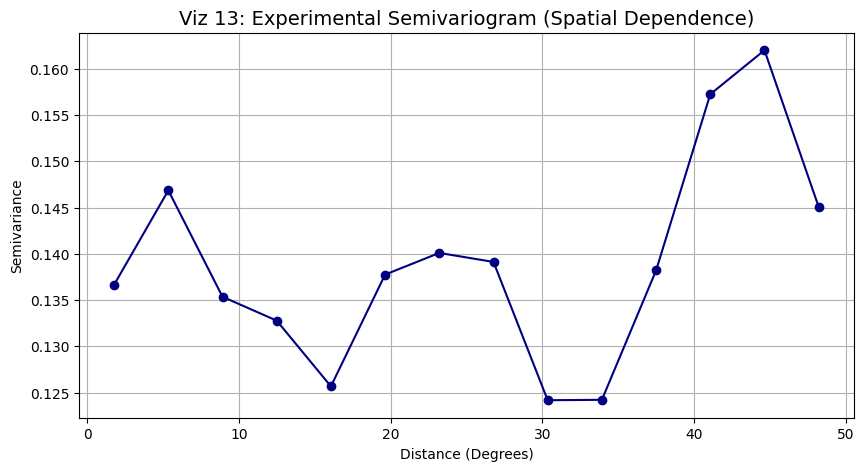

In [36]:
# Viz 13: Empirical Semivariogram

sub_var = df_sample.sample(1000, random_state=1)
coords = sub_var[['latitude', 'longitude']].values
vals = sub_var['mag'].values

# Calculate pairwise distance and squared difference
dists = pdist(coords)
sq_diffs = pdist(vals.reshape(-1,1), metric='sqeuclidean')

# Binning
bins = np.linspace(0, 50, 15)
bin_inds = np.digitize(dists, bins)
gamma = [0.5 * np.mean(sq_diffs[bin_inds == i]) for i in range(1, len(bins))]
centers = 0.5 * (bins[1:] + bins[:-1])

plt.figure(figsize=(10, 5))
plt.plot(centers, gamma, 'o-', color='navy')
plt.title('Viz 13: Experimental Semivariogram (Spatial Dependence)', fontsize=14)
plt.xlabel('Distance (Degrees)'); plt.ylabel('Semivariance')
plt.grid(True)
plt.show()

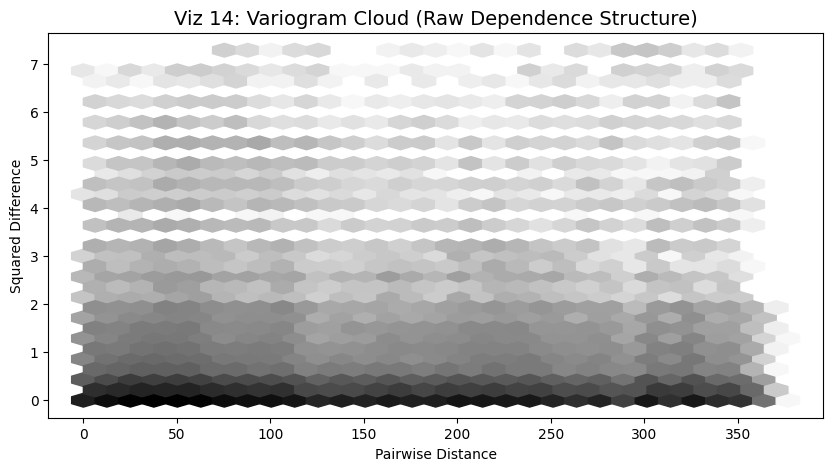

In [37]:
# Viz 14: Variogram Cloud (Raw Heterogeneity)

plt.figure(figsize=(10, 5))
plt.hexbin(dists, sq_diffs, gridsize=30, cmap='Greys', mincnt=1, xscale='linear', bins='log')
plt.title('Viz 14: Variogram Cloud (Raw Dependence Structure)', fontsize=14)
plt.xlabel('Pairwise Distance'); plt.ylabel('Squared Difference')
plt.show()

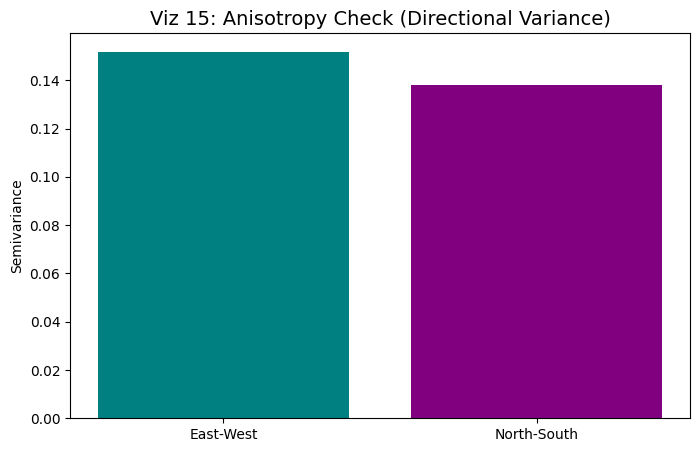

In [38]:
# Viz 15: Directional Anisotropy Check (Heterogeneity of Direction)

# Convert pandas Series → NumPy arrays
lon = sub_var.longitude.to_numpy()
lat = sub_var.latitude.to_numpy()
mag = sub_var.mag.to_numpy()

diff_lon = np.abs(np.subtract.outer(lon, lon))
diff_lat = np.abs(np.subtract.outer(lat, lat))
diff_mag = 0.5 * (np.subtract.outer(mag, mag))**2

# Filter pairs: E-W (High Lon diff, Low Lat diff) vs N-S (Low Lon diff, High Lat diff)
ew_var = diff_mag[(diff_lat < 5) & (diff_lon > 5)].mean()
ns_var = diff_mag[(diff_lon < 5) & (diff_lat > 5)].mean()

plt.figure(figsize=(8, 5))
plt.bar(['East-West', 'North-South'], [ew_var, ns_var], color=['teal', 'purple'])
plt.title('Viz 15: Anisotropy Check (Directional Variance)', fontsize=14)
plt.ylabel('Semivariance')
plt.show()

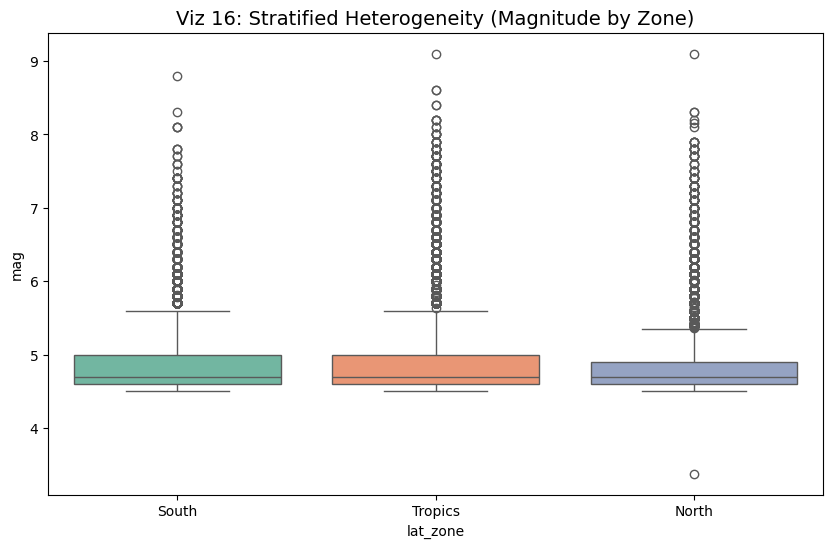

In [39]:
# Viz 16: Boxplot by Latitude Zone (Stratified Heterogeneity)

df_full['lat_zone'] = pd.cut(df_full['latitude'], bins=[-90, -23.5, 23.5, 90], labels=['South', 'Tropics', 'North'])

plt.figure(figsize=(10, 6))
sns.boxplot(x='lat_zone', y='mag', data=df_full, palette='Set2')
plt.title('Viz 16: Stratified Heterogeneity (Magnitude by Zone)', fontsize=14)
plt.show()

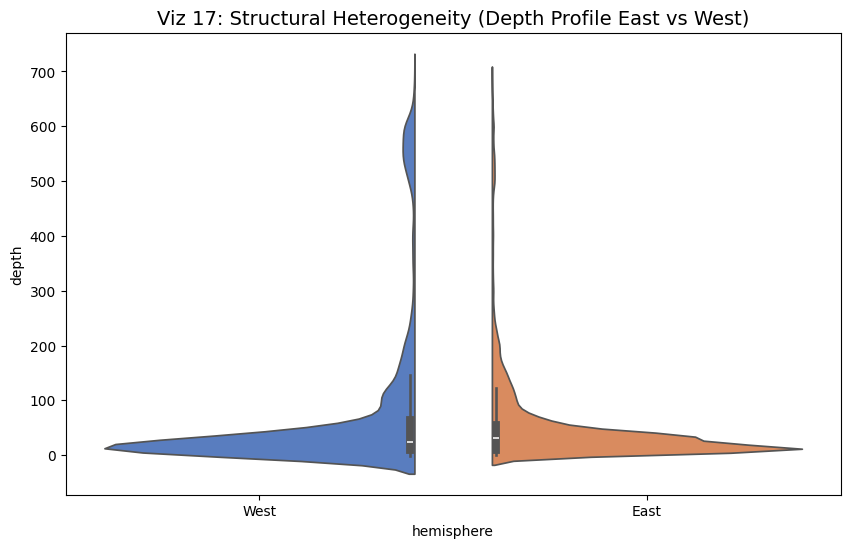

In [40]:
# Viz 17: Depth Distribution by Hemisphere (East vs West)

df_full['hemisphere'] = np.where(df_full['longitude'] < 0, 'West', 'East')

plt.figure(figsize=(10, 6))
sns.violinplot(x='hemisphere', y='depth', data=df_full, split=True, palette='muted')
plt.title('Viz 17: Structural Heterogeneity (Depth Profile East vs West)', fontsize=14)
plt.show()

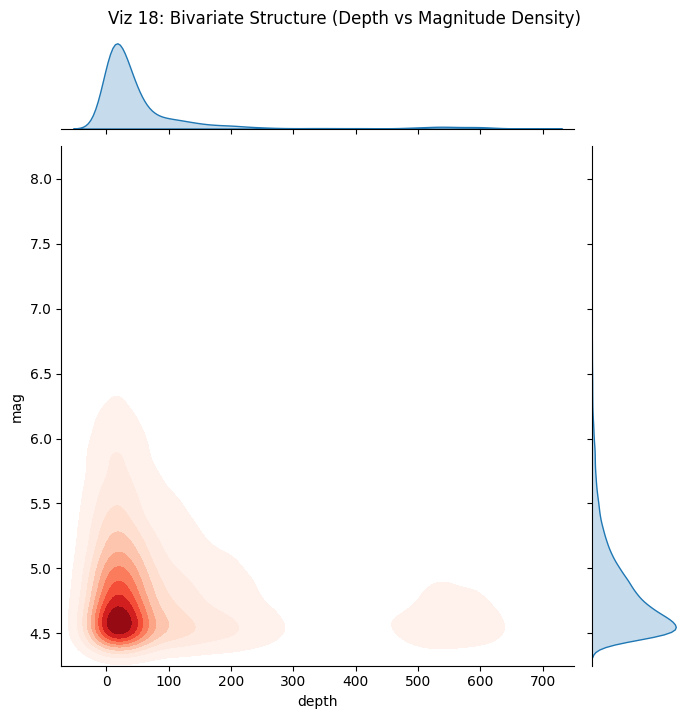

In [41]:
# Viz 18: Bivariate Joint Plot (Depth vs Mag)

sns.jointplot(x='depth', y='mag', data=df_sample, kind='kde', fill=True, cmap='Reds', height=7)
plt.suptitle('Viz 18: Bivariate Structure (Depth vs Magnitude Density)', y=1.02)
plt.show()

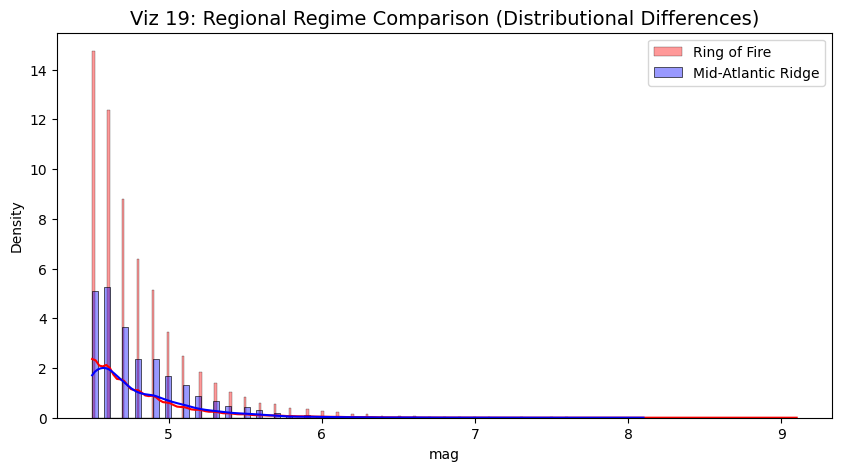

In [42]:
# Viz 19: Histogram Comparison (Ring of Fire vs Mid-Atlantic)

rof = df_full[(df_full['longitude'].between(120, 150))]
atl = df_full[(df_full['longitude'].between(-40, -20))]

plt.figure(figsize=(10, 5))
sns.histplot(rof['mag'], color='red', label='Ring of Fire', stat='density', alpha=0.4, kde=True)
sns.histplot(atl['mag'], color='blue', label='Mid-Atlantic Ridge', stat='density', alpha=0.4, kde=True)
plt.title('Viz 19: Regional Regime Comparison (Distributional Differences)', fontsize=14)
plt.legend()
plt.show()

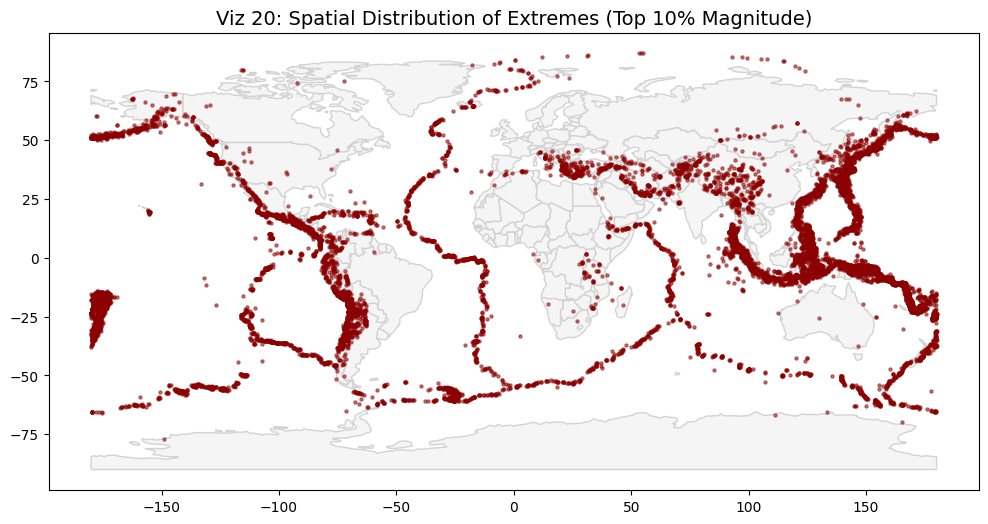

In [43]:
# Viz 20: Quantile Map (Top 10% Magnitudes)

top_10 = df_full[df_full['mag'] > df_full['mag'].quantile(0.9)]

fig, ax = plt.subplots(figsize=(12, 6))
if not world.empty: world.plot(ax=ax, color='whitesmoke', edgecolor='lightgrey')

ax.scatter(top_10['longitude'], top_10['latitude'], s=5, color='darkred', alpha=0.5)
plt.title('Viz 20: Spatial Distribution of Extremes (Top 10% Magnitude)', fontsize=14)
plt.show()